In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-top-1000-movies-and-tv-shows:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1131493%2F1898721%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240606%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240606T151156Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf35cd3da94ae9a5144ef76398cf9bf7c3ac86842a63d0ba5efc994577789d8d576980432d59a75404edcc3cbed2b9151a6c2c7062d90283b1c309f6395d22756a8a8f74f8df180aaf18e69300ccfc5946cf2d73e777bf236a8ed11d79466c4bf00505efe253a585c89e91aaad43b0cdf81bc5b729f25e1905d1ba60cf11a7c810f527f4f05e95c8800181e685750ff895221fa965aa821119f9fba026375eccbaf5d3382f12a7180997088bf363902ee89e48ed1270546833862b0f92da97273d2be754fc83e8e0a6e1158cbd891f08469bafb7c739758d20626b292b2c4e6f3e84b68a1b482fa57650d5bba826e0a639e9767c1424d39468aa0dd4a5793997'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from scipy.stats import skew
import statistics

In [ ]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv')

In [ ]:
df.isna().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum()

Poster_Link      0
Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64

In [ ]:
df.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

In [ ]:
df['Gross']=df['Gross'].str.replace(',', '')
df['Gross']=df['Gross'].astype(int)

In [ ]:
def estrai_durata(text):
    return re.sub(r'(\d+)\smin', r'\1', text)
df['Runtime']=df['Runtime'].apply(estrai_durata)
df['Runtime']= df['Runtime'].astype(int)

In [ ]:
df.columns

In [ ]:
df[df['Released_Year'] == "PG"]

In [ ]:
df['Released_Year']=df['Released_Year'].replace("PG","1995")

In [ ]:
df['Released_Year']= df['Released_Year'].astype(int)

In [ ]:
df.dtypes

In [ ]:
df.set_index('Released_Year',inplace = True)

In [ ]:
df.head(3)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


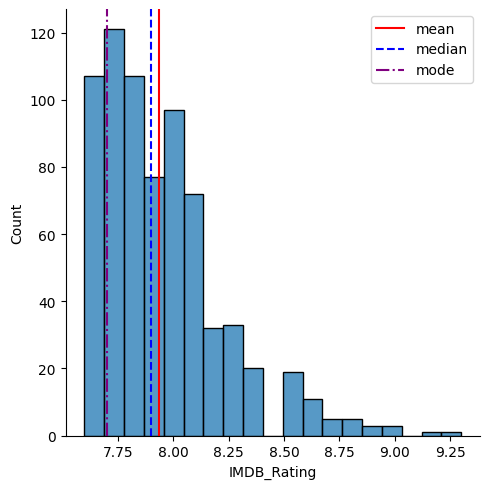

In [ ]:
sns.displot(df['IMDB_Rating'])
plt.axvline(x=np.mean(df['IMDB_Rating']), c = 'red', ls = 'solid', label = 'mean')
plt.axvline(x=np.median(df['IMDB_Rating']), c = 'blue', ls = 'dashed', label = 'median')
plt.axvline(x=statistics.mode(df['IMDB_Rating']), c = 'purple', ls = 'dashdot', label = 'mode')
plt.legend()

In [ ]:
skewness = skew(df['IMDB_Rating'])
print("Skewness:", skewness)

Skewness: 1.187115419488503


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


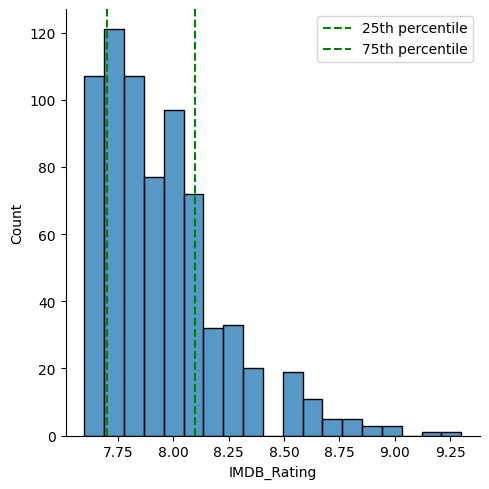

In [ ]:
sns.displot(df['IMDB_Rating'])
plt.axvline(x=np.percentile(df['IMDB_Rating'],25), c = 'green', ls = '--', label = '25th percentile')
plt.axvline(x=np.percentile(df['IMDB_Rating'],75), c = 'green', ls = '--', label = '75th percentile')
plt.legend()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


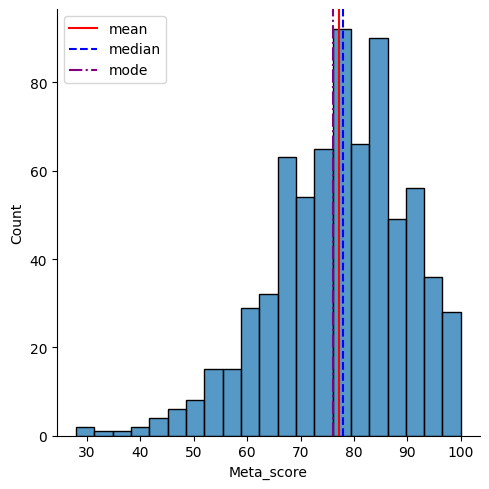

In [ ]:
sns.displot(df['Meta_score'])
plt.axvline(x=np.mean(df['Meta_score']), c = 'red', ls = 'solid', label = 'mean')
plt.axvline(x=np.median(df['Meta_score']), c = 'blue', ls = 'dashed', label = 'median')
plt.axvline(x=statistics.mode(df['Meta_score']), c = 'purple', ls = 'dashdot', label = 'mode')
plt.legend()

In [ ]:
skewness = skew(df['Meta_score'])
print("Skewness:", skewness)

Skewness: -0.5846642197984754


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


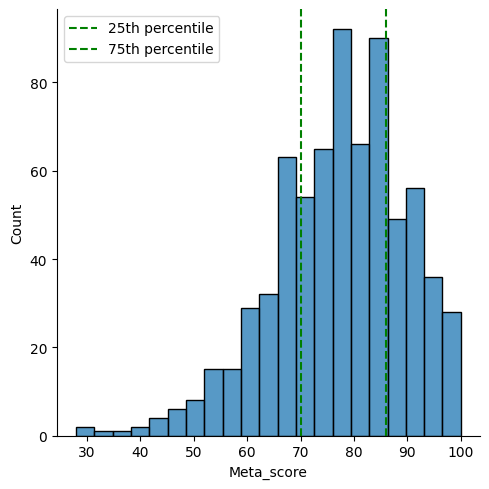

In [ ]:
sns.displot(df['Meta_score'])
plt.axvline(x=np.percentile(df['Meta_score'],25), c = 'green', ls = '--', label = '25th percentile')
plt.axvline(x=np.percentile(df['Meta_score'],75), c = 'green', ls = '--', label = '75th percentile')
plt.legend()

In [ ]:
df['Genre'] = df['Genre'].apply(lambda x: x.split(', '))
df_count = df.explode('Genre')
df_count.head()

In [ ]:
df_count['Genre'].value_counts()

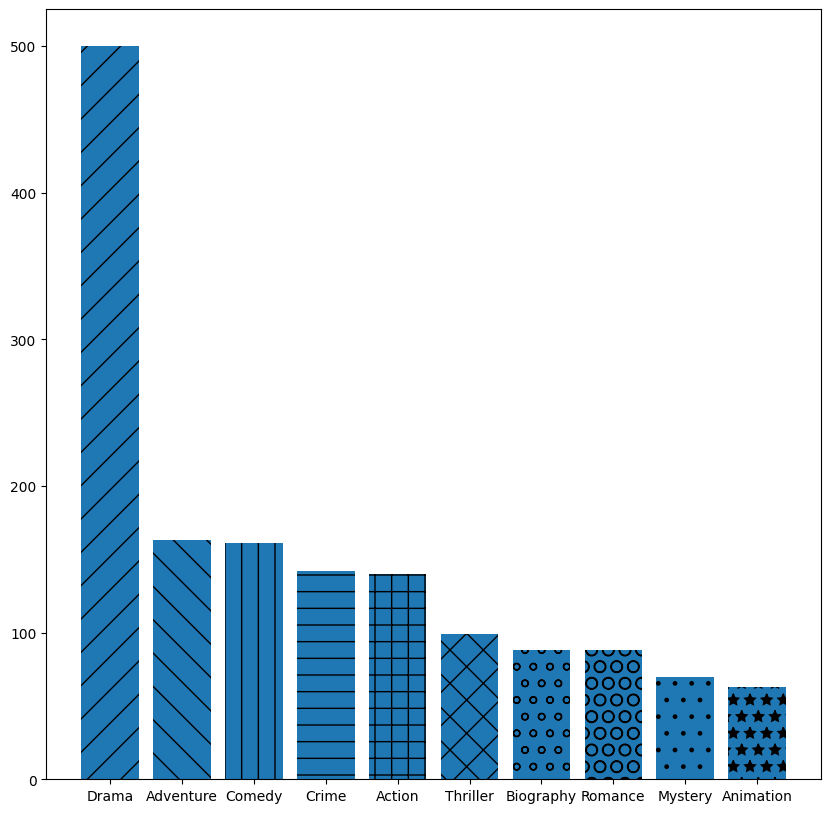

In [ ]:
plt.figure(figsize=(10, 10))
bars = plt.bar(df_count['Genre'].value_counts().head(10).index,df_count['Genre'].value_counts().head(10).values)
patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


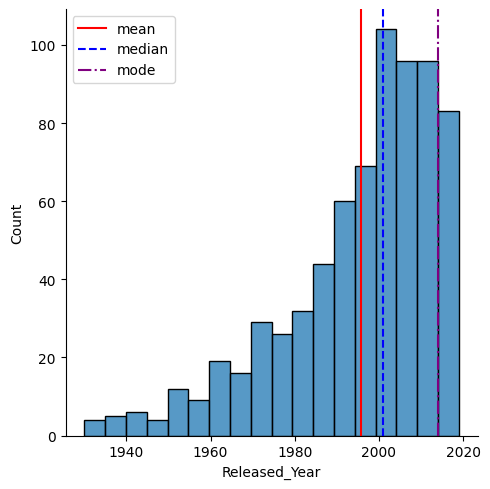

In [ ]:
sns.displot(df.index)
plt.axvline(x=np.mean(df.index), c = 'red', ls = 'solid', label = 'mean')
plt.axvline(x=np.median(df.index), c = 'blue', ls = 'dashed', label = 'median')
plt.axvline(x=statistics.mode(df.index), c = 'purple', ls = 'dashdot', label = 'mode')
plt.legend()

In [ ]:
skewness = skew(df.index)
print("Skewness:", skewness)

Skewness: -1.1446712164330908


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


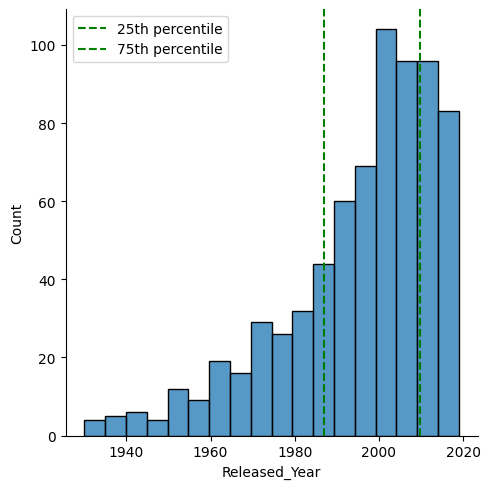

In [ ]:
sns.displot(df.index)
plt.axvline(x=np.percentile(df.index,25), c = 'green', ls = '--', label = '25th percentile')
plt.axvline(x=np.percentile(df.index,75), c = 'green', ls = '--', label = '75th percentile')
plt.legend()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


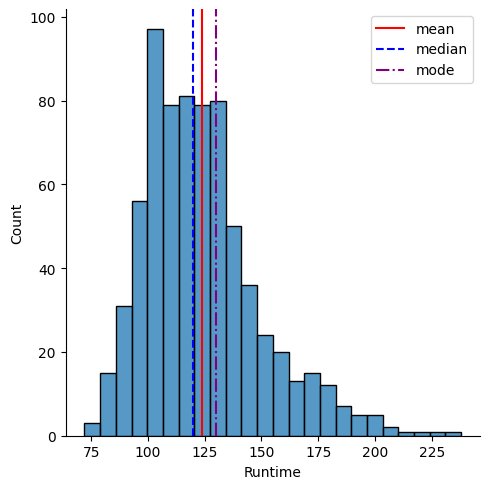

In [ ]:
sns.displot(df['Runtime'])
plt.axvline(x=np.mean(df['Runtime']), c = 'red', ls = 'solid', label = 'mean')
plt.axvline(x=np.median(df['Runtime']), c = 'blue', ls = 'dashed', label = 'median')
plt.axvline(x=statistics.mode(df['Runtime']), c = 'purple', ls = 'dashdot', label = 'mode')
plt.legend()

In [ ]:
df['Director'].value_counts().head(10)

Director
Steven Spielberg     13
Martin Scorsese      10
Alfred Hitchcock      9
Christopher Nolan     8
Clint Eastwood        8
Quentin Tarantino     8
David Fincher         8
Hayao Miyazaki        7
Rob Reiner            7
Woody Allen           7
Name: count, dtype: int64

<Axes: xlabel='Director', ylabel='IMDB_Rating'>

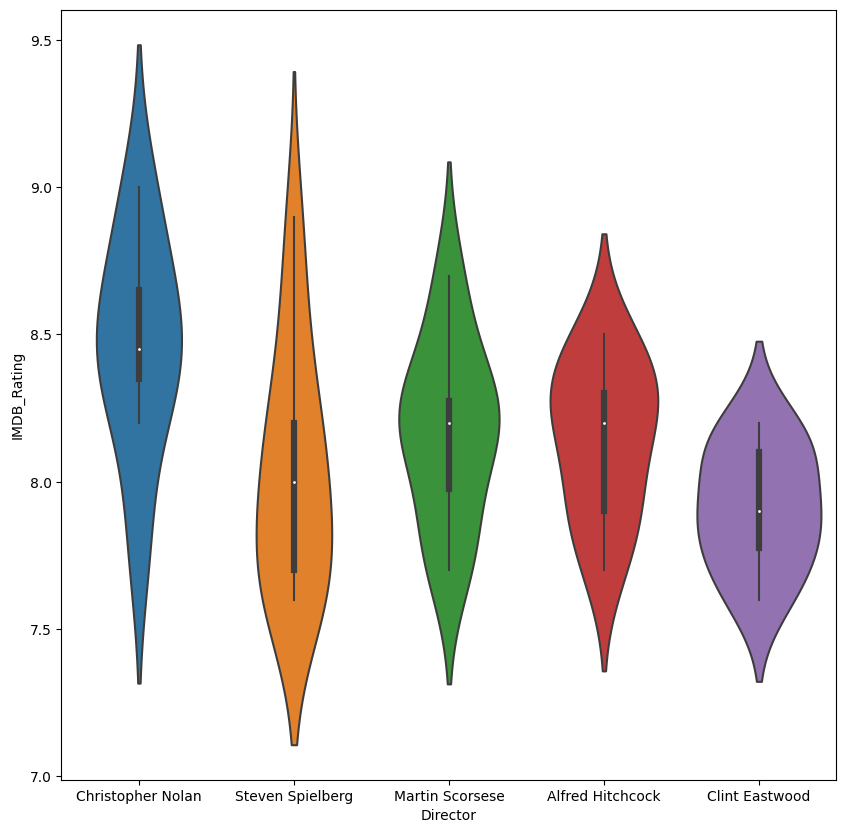

In [ ]:
top_directors = df['Director'].value_counts().head(5).index
filtered_df = df[df['Director'].isin(top_directors)]
plt.figure(figsize=(10, 10))
sns.violinplot(x='Director', y='IMDB_Rating', data=filtered_df)


<Axes: xlabel='Director', ylabel='Meta_score'>

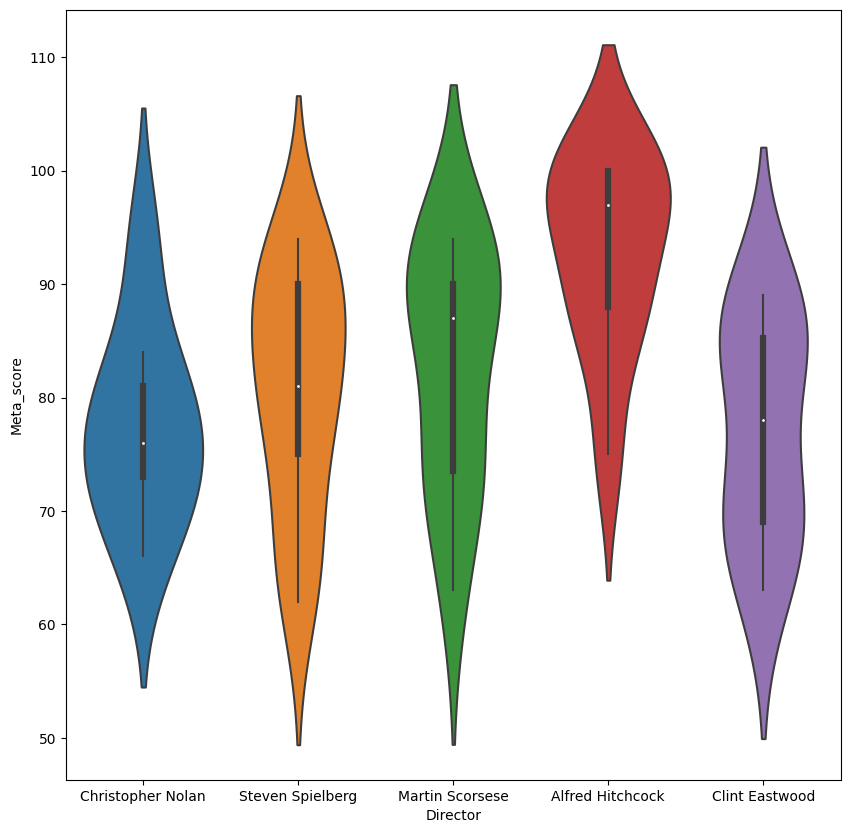

In [ ]:
plt.figure(figsize=(10, 10))

sns.violinplot(x='Director', y='Meta_score', data=filtered_df)

In [ ]:
top_genre = df_count['Genre'].value_counts().head(5).index
df_count['Runtime']=df_count['Runtime'].apply(estrai_durata)
df_count['Runtime']= df_count['Runtime'].astype(int)

In [ ]:
df_count.dtypes

Poster_Link      object
Series_Title     object
Certificate      object
Runtime           int64
Genre            object
IMDB_Rating     float64
Overview         object
Meta_score      float64
Director         object
Star1            object
Star2            object
Star3            object
Star4            object
No_of_Votes       int64
Gross             int64
dtype: object

<Axes: xlabel='Genre', ylabel='Runtime'>

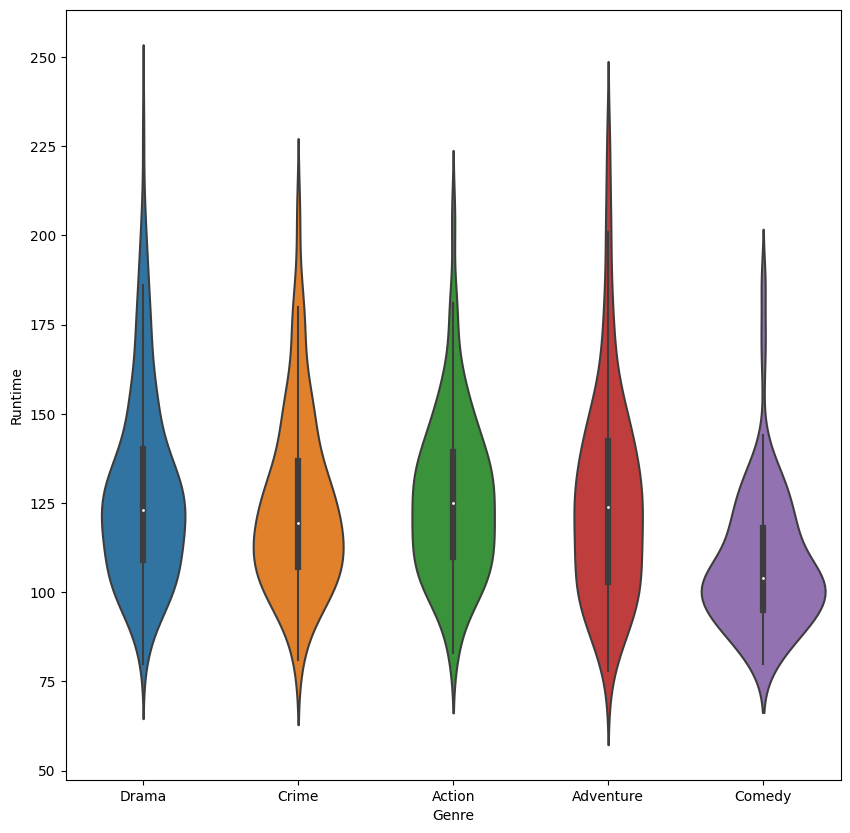

In [ ]:
filtered_df= df_count[df_count['Genre'].isin(top_genre)]
plt.figure(figsize=(10, 10))
sns.violinplot(x='Genre', y='Runtime', data=filtered_df)

<Axes: xlabel='Released_Year', ylabel='IMDB_Rating'>

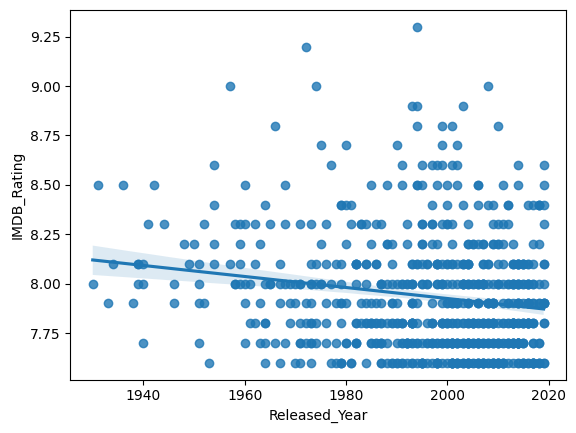

In [ ]:
sns.regplot( x=df.index, y=df['IMDB_Rating'])

<Axes: xlabel='Released_Year', ylabel='Meta_score'>

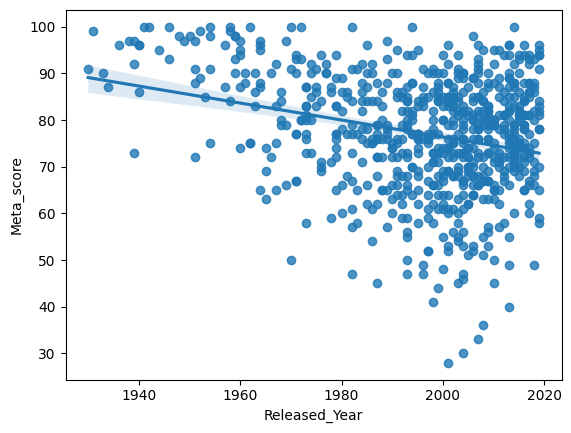

In [ ]:
sns.regplot( x=df.index, y=df['Meta_score'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


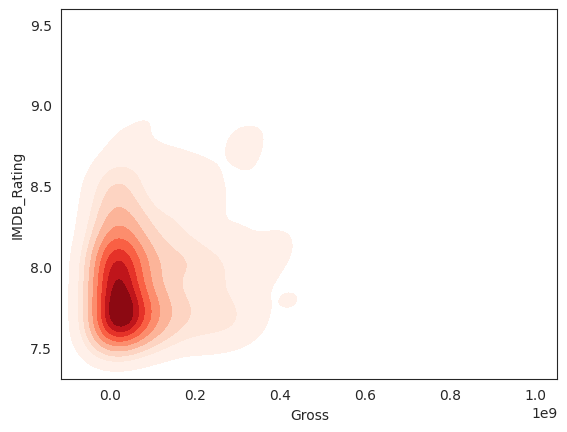

In [ ]:
sns.set_style("white")
sns.kdeplot(x=df["Gross"], y=df["IMDB_Rating"],cmap="Reds", fill=True)
plt.show()


In [ ]:
all_stars.value_counts().head(20)

robert de niro        16
tom hanks             14
al pacino             13
brad pitt             12
christian bale        11
matt damon            11
clint eastwood        11
leonardo dicaprio     11
scarlett johansson     9
denzel washington      9
johnny depp            9
ethan hawke            9
harrison ford          8
morgan freeman         7
ian mckellen           7
bruce willis           7
edward norton          7
russell crowe          7
emma watson            7
jeff bridges           7
Name: count, dtype: int64

In [ ]:
df.reset_index()
df['Star1'] = df['Star1'].str.lower().str.strip()
df['Star2'] = df['Star2'].str.lower().str.strip()
df['Star3'] = df['Star3'].str.lower().str.strip()
df['Star4'] = df['Star4'].str.lower().str.strip()

all_stars = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']])
top_20_actors = all_stars.value_counts().head(20)
Star1 = df.groupby('Star1')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star1 = Star1[Star1.index.isin(top_20_actors.index)]
Star2= df.groupby('Star2')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star2= Star2[Star2.index.isin(top_20_actors)]
Star3= df.groupby('Star3')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star3= Star3[Star3.index.isin(top_20_actors)]
Star4= df.groupby('Star4')['IMDB_Rating'].mean().sort_values(ascending=False)
filter_star4= Star4[Star4.index.isin(top_20_actors)]

In [ ]:
all_actors = filter_star1.index.union(filter_star2.index).union(filter_star3.index).union(filter_star4.index)
unique_actors = pd.Index(all_actors).unique()
df_actors = pd.DataFrame(unique_actors, columns=['Star'])
df_actors['Average_Rating'] = 0.0

for idx, row in df_actors.iterrows():
    actor = row['Star']
    ratings = []

    if actor in filter_star1.index:
        ratings.append(filter_star1[actor])
    if actor in filter_star2.index:
        ratings.append(filter_star2[actor])
    if actor in filter_star3.index:
        ratings.append(filter_star3[actor])
    if actor in filter_star4.index:
        ratings.append(filter_star4[actor])

    if ratings:
        average_rating = sum(ratings) / len(ratings)
    else:
        average_rating = 0

    df_actors.at[idx, 'Average_Rating'] = average_rating
df_actors.sort_values(by='Average_Rating', ascending=False)

,Star,Average_Rating
0,leonardo dicaprio,8.133333
1,brad pitt,8.125000
2,christian bale,8.112500
3,harrison ford,8.100000
4,morgan freeman,8.100000
5,tom hanks,8.041667
6,russell crowe,8.040000
7,robert de niro,8.040000
8,al pacino,8.010000
9,clint eastwood,7.970000


In [ ]:
corr = np.round(df.select_dtypes(include=[np.number]).corr(),2)


<Axes: >

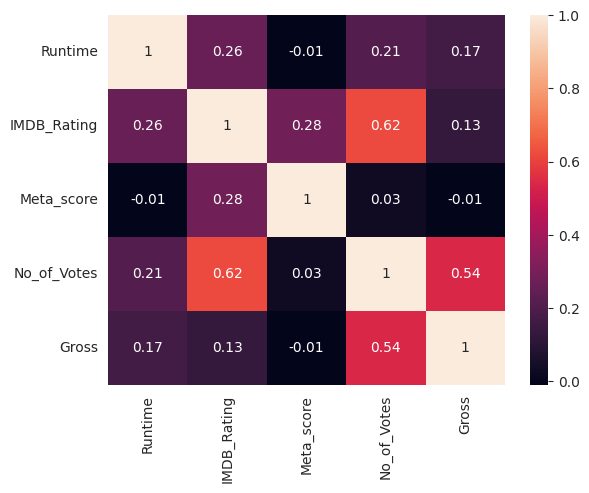

In [ ]:
sns.heatmap(corr, annot = True)